# Estimating country means OOC

Do our debiasing methods work under domain shift, i.e. where the training data and test/trial data come from separate domains? In order to test this, we run an experiment for each country where we attempt to estimate its mean IWI using a model trained on the other countries. This represents the "Out-of-country" (OOC) setting that we have discussed in earlier papers. After the model has been fitted, we make predictions for the target country and estimate its average IWI using our collection of debiasing methods. Ideally, these debiased estimates should then give an unbiased estimate of the country's means while the unprocessed estimates should give a mean estimate closer to 0.

In [1]:
import os
import configparser
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from utils import RegressionModel, train_model, plot_results
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sns.set_theme()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the image embeddings and DHS information for our big dataset (~69k entries).

In [2]:
RANDOM_STATE = 42
N_COMPONENTS = 232

embeddings = np.load(os.path.join(DATA_DIR, 'ssl4eo_resnet50.npy'))
df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_with_imgs.csv'))

assert embeddings.shape[0] == df.shape[0], 'Mismatch between embeddings and metadata rows.'

X = embeddings

# Cheat by doing rescaling and PCA on the whole set
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=N_COMPONENTS)
X = pca.fit_transform(X)

Y = df['iwi'].values / 100.0 # Scale IWI to [0, 1]
Y = Y.clip(0, 1)

X = torch.tensor(X, dtype=torch.float).to(device)
Y = torch.tensor(Y, dtype=torch.float).to(device)

Utility methods

In [3]:
def mse_loss(pred, target):
    mse = nn.MSELoss()(pred, target)
    return mse, {'MSE': mse.item()}

def score_function(y, kde, delta=1e-5):
    # Derivative of log density
    log_p_plus = kde.logpdf(y + delta)[0]
    log_p_minus = kde.logpdf(y - delta)[0]
    d_logp = (log_p_plus - log_p_minus) / (2 * delta)
    return d_logp

Run the experiment for each country. Save the results in a dataframe

In [ ]:
results = {
    'country': [],
    'r2': [],
    'mae': [],
    'country_target_mean': [],
    'country_pred_mean': [],
    'country_tweedies_mean': [],
    'country_km_mean': [],
    'country_ppi_mean': []
}

countries = df['country'].unique()

n_labeled_samples = 10

for country in tqdm(countries):

    # Split data into train, validation, and test sets
    # Use data from the current country as a test and the rest as training/validation
    test_ixs = df['country'] == country
    X_train = X[~test_ixs]
    X_test = X[test_ixs]
    y_train = Y[~test_ixs]
    y_test = Y[test_ixs]
    df_train = df[~test_ixs]
    df_test = df[test_ixs]
    X_train, X_val, y_train, y_val, df_train, df_val = train_test_split(X_train, y_train, df_train, test_size=0.2, random_state=RANDOM_STATE)

    # Train model on data from other countries
    mse_model = train_model(X_train, X_val, y_train, y_val, lr=1e-4, l2=1e-2, loss_fn=mse_loss, verbose=0)

    # Evaluate model on test set
    with torch.no_grad():
        predictions = 100 * mse_model(X_test).cpu().numpy()
        val_predictions = 100 * mse_model(X_val).cpu().numpy()
        targets = 100 * y_test.cpu().numpy()
        val_targets = 100 * y_val.cpu().numpy()

    # Calculate metrics
    r2 = r2_score(targets, predictions)
    mae = mean_absolute_error(targets, predictions)

    # Get values for Tweedie's correction
    pred_kde = gaussian_kde(val_predictions)
    res_std = (val_predictions - val_targets).std()
    prediction_scores = np.array([score_function(y, pred_kde) for y in predictions])

    # Get values for km correction
    km_regressor = LinearRegression()
    km_regressor.fit(val_targets.reshape(-1, 1), val_predictions)

    k = km_regressor.coef_[0]
    m = km_regressor.intercept_
    km_predictions = (predictions - m) / k

    # Get the true and predicted IWI means for the country
    country_target_mean = targets.mean()
    country_pred_mean = predictions.mean()
    country_tweedies_mean = country_pred_mean - res_std**2 * prediction_scores.mean()
    country_km_mean = km_predictions.mean()

    # Do PPI correction
    indices = np.random.choice(len(targets), size=min(n_labeled_samples, len(targets)), replace=False)
    ppi_correction = (targets[indices] - predictions[indices]).mean()
    country_ppi_mean = country_pred_mean + ppi_correction

    # Store results
    results['country'].append(country)
    results['r2'].append(r2)
    results['mae'].append(mae)
    results['country_target_mean'].append(country_target_mean)
    results['country_pred_mean'].append(country_pred_mean)
    results['country_tweedies_mean'].append(country_tweedies_mean)
    results['country_km_mean'].append(country_km_mean)
    results['country_ppi_mean'].append(country_ppi_mean)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

100%|██████████| 38/38 [08:47<00:00, 13.89s/it]


Make scatter plots showing the relationship between the mean target IWI and the predicted mean IWI. Each dot represents a country.

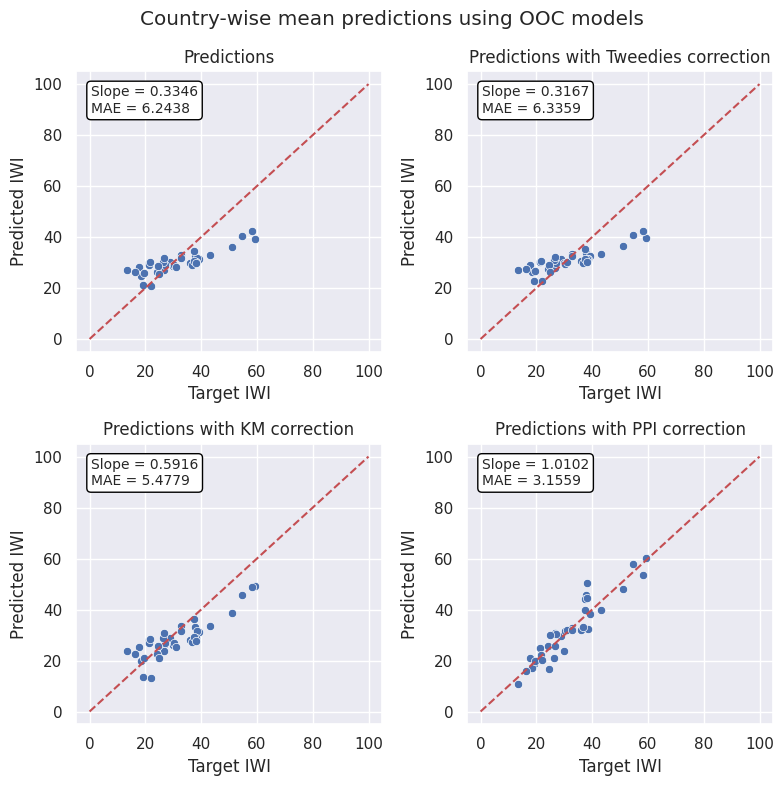

In [5]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
sns.scatterplot(data=results_df, x='country_target_mean', y='country_pred_mean')
mae = mean_absolute_error(results_df['country_target_mean'], results_df['country_pred_mean'])
slope, _ = np.polyfit(results_df['country_target_mean'], results_df['country_pred_mean'], 1)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Target IWI')
plt.ylabel('Predicted IWI')
plt.title('Predictions')

plt.subplot(2, 2, 2)
sns.scatterplot(data=results_df, x='country_target_mean', y='country_tweedies_mean')
mae = mean_absolute_error(results_df['country_target_mean'], results_df['country_tweedies_mean'])
slope, _ = np.polyfit(results_df['country_target_mean'], results_df['country_tweedies_mean'], 1)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Target IWI')
plt.ylabel('Predicted IWI')
plt.title('Predictions with Tweedies correction')

plt.subplot(2, 2, 3)
sns.scatterplot(data=results_df, x='country_target_mean', y='country_km_mean')
mae = mean_absolute_error(results_df['country_target_mean'], results_df['country_km_mean'])
slope, _ = np.polyfit(results_df['country_target_mean'], results_df['country_km_mean'], 1)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Target IWI')
plt.ylabel('Predicted IWI')
plt.title('Predictions with KM correction')

plt.subplot(2, 2, 4)
sns.scatterplot(data=results_df, x='country_target_mean', y='country_ppi_mean')
mae = mean_absolute_error(results_df['country_target_mean'], results_df['country_ppi_mean'])
slope, _ = np.polyfit(results_df['country_target_mean'], results_df['country_ppi_mean'], 1)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Target IWI')
plt.ylabel('Predicted IWI')
plt.title('Predictions with PPI correction')
plt.tight_layout()

plt.suptitle('Country-wise mean predictions using OOC models')
plt.tight_layout()

We had hoped that the two corrected predictions should have a slope of one, and although they are better than the unprocessed predictions, this is far from the case. The mean IWI predictions are therefore biased such that the wealthier a cohort is, the likelier it is that we underestimate the cohort mean. This will make us unable to determine an unbiased estimate of an ATE, which is the difference between two (possibly weighted) cohort means.

## Compare to models where country is in the training set

As a comparison, this is what the experiment looks like when the country appears in the training set

In [8]:
in_country_results = {
    'country': [],
    'r2': [],
    'mae': [],
    'country_target_mean': [],
    'country_pred_mean': [],
    'country_tweedies_mean': [],
    'country_km_mean': []
}

X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(X, Y, df, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val, df_train, df_val = train_test_split(X_train, y_train, df_train, test_size=0.25, random_state=RANDOM_STATE)

# Train model on data from other countries
mse_model = train_model(X_train, X_val, y_train, y_val, lr=1e-4, l2=1e-2, loss_fn=mse_loss, verbose=0)

# Evaluate model on test set
with torch.no_grad():
    predictions = 100 * mse_model(X_test).cpu().numpy()
    val_predictions = 100 * mse_model(X_val).cpu().numpy()
    targets = 100 * y_test.cpu().numpy()
    val_targets = 100 * y_val.cpu().numpy()

# Get values for Tweedie's correction
pred_kde = gaussian_kde(val_predictions)
res_std = (val_predictions - val_targets).std()
prediction_scores = np.array([score_function(y, pred_kde) for y in predictions])

# Get values for km correction
km_regressor = LinearRegression()
km_regressor.fit(val_targets.reshape(-1, 1), val_predictions)

k = km_regressor.coef_[0]
m = km_regressor.intercept_
km_predictions = (predictions - m) / k

for country in tqdm(countries):

    # Split data into train, validation, and test sets
    # Use data from the current country as a test and the rest as training/validation
    test_ixs = df_test['country'] == country

    country_targets = targets[test_ixs]
    country_predictions = predictions[test_ixs]
    country_prediction_scores = prediction_scores[test_ixs]
    country_km_predictions = km_predictions[test_ixs]

    # Calculate metrics
    r2 = r2_score(country_targets, country_predictions)
    mae = mean_absolute_error(country_targets, country_predictions)

    # Get the true and predicted IWI means for the country
    country_target_mean = country_targets.mean()
    country_pred_mean = country_predictions.mean()
    country_tweedies_mean = country_pred_mean - res_std**2 * country_prediction_scores.mean()
    country_km_mean = country_km_predictions.mean()

    # Store results
    in_country_results['country'].append(country)
    in_country_results['r2'].append(r2)
    in_country_results['mae'].append(mae)
    in_country_results['country_target_mean'].append(country_target_mean)
    in_country_results['country_pred_mean'].append(country_pred_mean)
    in_country_results['country_tweedies_mean'].append(country_tweedies_mean)
    in_country_results['country_km_mean'].append(country_km_mean)

# Convert in_country_results to DataFrame
in_country_results_df = pd.DataFrame(in_country_results)

100%|██████████| 38/38 [00:00<00:00, 754.61it/s]


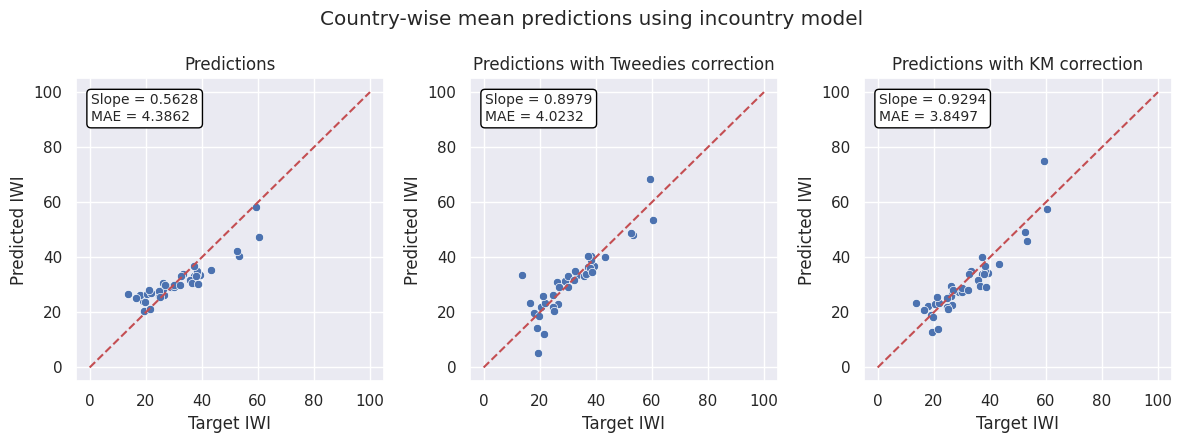

In [9]:
plt.figure(figsize=(12, 4.5))
plt.subplot(1, 3, 1)
sns.scatterplot(data=in_country_results_df, x='country_target_mean', y='country_pred_mean')
mae = mean_absolute_error(in_country_results_df['country_target_mean'], in_country_results_df['country_pred_mean'])
slope, _ = np.polyfit(in_country_results_df['country_target_mean'], in_country_results_df['country_pred_mean'], 1)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Target IWI')
plt.ylabel('Predicted IWI')
plt.title('Predictions')

plt.subplot(1, 3, 2)
sns.scatterplot(data=in_country_results_df, x='country_target_mean', y='country_tweedies_mean')
mae = mean_absolute_error(in_country_results_df['country_target_mean'], in_country_results_df['country_tweedies_mean'])
slope, _ = np.polyfit(in_country_results_df['country_target_mean'], in_country_results_df['country_tweedies_mean'], 1)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Target IWI')
plt.ylabel('Predicted IWI')
plt.title('Predictions with Tweedies correction')

plt.subplot(1, 3, 3)
sns.scatterplot(data=in_country_results_df, x='country_target_mean', y='country_km_mean')
mae = mean_absolute_error(in_country_results_df['country_target_mean'], in_country_results_df['country_km_mean'])
slope, _ = np.polyfit(in_country_results_df['country_target_mean'], in_country_results_df['country_km_mean'], 1)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Target IWI')
plt.ylabel('Predicted IWI')
plt.title('Predictions with KM correction')

plt.suptitle('Country-wise mean predictions using incountry model')
plt.tight_layout()

Now, the predictions appear unbiased